In [1]:
from SimPEG import *
from simpegEM1D import (
    EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, 
    set_mesh_1d, skytem_HM_2015
)
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [89]:
from simpegEM1D import skytem_HM_2015
time = np.logspace(np.log10(1e-6), -2, 41)
hz = 0.5 * 1.1**(np.arange(25))
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC
src = np.r_[4.88927250e+05, 5.98386447e+06, 3.73558738e+02]
rxOffset = np.r_[0, 0, -32]
TDsurvey = EM1DSurveyTD(
    rx_location = src+rxOffset,
    src_location = src,
    topo = np.r_[src[:2], src[2]-100.],
    depth = depth,
    rx_type = 'Bz',
    wave_type = 'stepoff',
    src_type = 'VMD',
    I = 1.,
    offset=np.r_[136.],
    time = time,
    base_frequency = 50.,
)
sig_half = 1./20.
sig_blk = 1./20.
chi_half = 0.
expmap = Maps.ExpMap(mesh1D)

In [90]:
sig  = np.ones(TDsurvey.n_layer)*sig_half
blk_ind = (0>LocSigZ) & (-2<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.log(sig)

(50, 0)

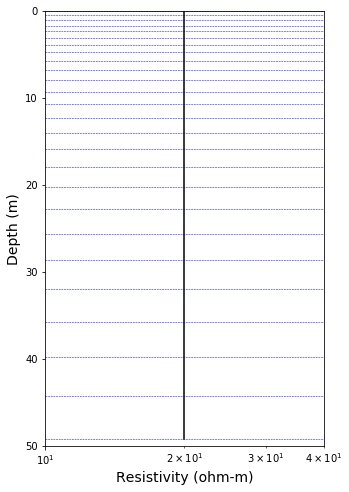

In [91]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(1./sig, mesh1D, showlayers=True, ax=ax)
ax.set_xlabel("Resistivity (ohm-m)")
plt.ylim(50, 0)

In [92]:
%%time
prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
d_true = TDsurvey.dpred(m_true)

Wall time: 88.8 ms


In [117]:
from scipy.constants import mu_0

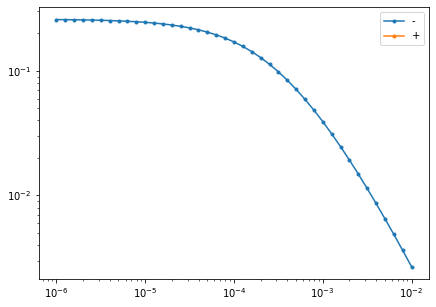

In [119]:
fig, axes = subplots(1,1, figsize = (7,5))
import geoana
mag_dipole = geoana.em.static.MagneticDipoleWholeSpace(sigma=0., orientation='Z')
bp = mag_dipole.magnetic_flux_density(np.array([[136, 0, -32]]))
axes.plot(TDsurvey.time, -d_true/bp[0, 2], '.-')
axes.plot(TDsurvey.time, +d_true/bp[0, 2], '.-')
axes.set_xscale('log');
axes.set_yscale('log');
plt.legend(('-', '+'))

In [76]:
rx-src

array([136.,   0.,   0.])

In [77]:
np.random.seed(1)
TDsurvey.dtrue = d_true
std = 0.03
noise = std*abs(TDsurvey.dtrue)*np.random.randn(*TDsurvey.dtrue.shape)
floor = 0.
std = 0.03
TDsurvey.dobs = TDsurvey.dtrue+noise
uncert = abs(TDsurvey.dobs)*std+floor

In [9]:
dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
uncert = (abs(TDsurvey.dobs)*std+floor)
dmisfit.W = 1./ uncert

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [10]:
m0 = np.log(np.ones_like(sig)*sig_half)
d_0 = TDsurvey.dpred(m0)
# delta = prob.get_threshold(uncert)

In [11]:
reg = Regularization.Sparse(
    mesh1D,
    mapping=Maps.IdentityMap(mesh1D),
    alpha_s=1e-3,
    alpha_x=1.,
)
p = 0
qx, qz = 0., 0.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=20, minGNiter=1, fix_Jmatrix=False, coolingRate=2, betaSearch=False,
    chifact_start = 1., f_min_change=1e-3
)
opt = Optimization.ProjectedGNCG(maxIter = 50, maxIterCG=30, tolG=1e-30, eps=1e-30)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2., coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = Directives.TargetMisfit()
# update_sense = Directives.UpdateSensitivityWeights(threshold=delta)
precond = Directives.UpdatePreconditioner()
# inv = Inversion.BaseInversion(invProb, directiveList=[IRLS, betaest, precond])
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target, precond])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

In [12]:
%%time
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.85e+03  1.29e+02  0.00e+00  1.29e+02    2.37e+02      0              
   1  3.93e+03  3.38e+01  1.75e-03  4.07e+01    6.18e+01      0              
   2  1.96e+03  2.53e+01  2.77e-03  3.08e+01    1.82e+01      0              
   3  9.81e+02  2.08e+01  4.44e-03  2.51e+01    1.27e+01      0   Skip BFGS  
   4  4.91e+02  1.77e+01  6.63e-03  2.10e+01    8.70e+00      0   Skip BFGS  
   5  2.45e+02  1.58e+01  9.39e-03  1.81e+01    5.67e+00      0   Skip BFGS  
----------------------

In [13]:
opt.counter.summary()
xc = opt.recall('xc')

Counters:
  ProjectedGNCG.activeSet                 :        6
  ProjectedGNCG.doEndIteration            :        6
  ProjectedGNCG.doStartIteration          :        6
  ProjectedGNCG.projection                :       27
  ProjectedGNCG.scaleSearchDirection      :        6

Times:                                        mean      sum
  EM1D.Jtvec_approx                       : 2.18e-04, 1.90e-02,   87x
  EM1D.Jvec_approx                        : 4.85e-03, 4.22e-01,   87x
  ProjectedGNCG.findSearchDirection       : 5.12e-02, 3.07e-01,    6x
  ProjectedGNCG.minimize                  : 3.18e+00, 3.18e+00,    1x
  ProjectedGNCG.modifySearchDirection     : 1.04e-01, 6.22e-01,    6x


Text(0.5, 0, 'Resistivity (ohm-m)')

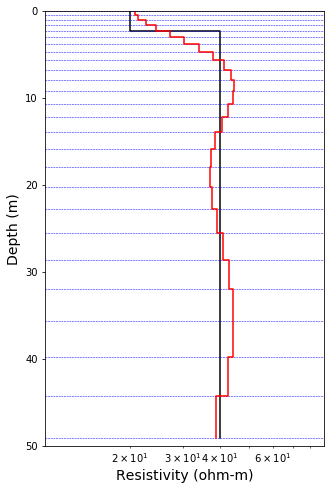

In [14]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(1./sig, mesh1D, ax=ax)
Utils1D.plotLayer(1./(expmap*mopt), mesh1D, showlayers=True, **{'color':'r'}, ax=ax)
# Utils1D.plotLayer(1/(expmap*invProb.l2model), mesh1D, showlayers=True, **{'color':'r'}, ax=ax)
ax.set_ylim(50, 0)
ax.set_xlabel("Resistivity (ohm-m)")

In [16]:
# titles = ['Smooth', 'Sharp']
# fig, axs = subplots(1,2, figsize=(10, 8))
# for ii, ax in enumerate(axs):
#     Utils1D.plotLayer(1./sig, mesh1D, ax=ax)
# Utils1D.plotLayer(1./(expmap*mopt), mesh1D, showlayers=True, **{'color':'r'}, ax=axs[1])
# Utils1D.plotLayer(1/(expmap*invProb.l2model), mesh1D, showlayers=True, **{'color':'r'}, ax=axs[0])
# for ii, ax in enumerate(axs):
#     ax.set_xlabel("Resistivity (ohm-m)")
#     ax.set_title(titles[ii], fontsize=14)

# axs[1].set_ylabel('')
# ax.set_ylim(50, 0)

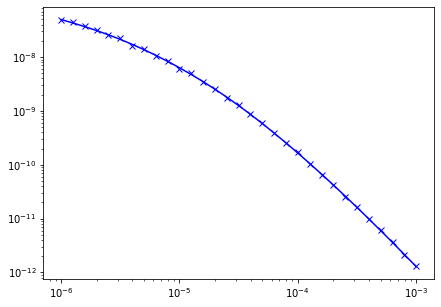

In [17]:
fig, axes = plt.subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -invProb.dpred, 'b-')
axes.plot(TDsurvey.time, -TDsurvey.dobs, 'bx')
axes.set_xscale('log');
axes.set_yscale('log');